## Glacier surface process characterization with gee

#### June 07 

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from shapely.geometry import Point
from matplotlib import pyplot as plt

import ee

import geemap #bless these people

import json

import os

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1ASVgi3LvhWHrZdRyyAE82rYkKMq3gL1EQi4g1tiB146RqzWHWzF6AoF7Q5o



Successfully saved authorization token.


In [3]:
# Define the region of interest (Everest)
everest = ee.Geometry.Rectangle(86.5, 27.7, 87.3, 28.2)

# Define the date range
start_date = '2020-01-01'
end_date = '2020-12-31'

# Define the Landsat Collection 2 Level-2 collection
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Filter the collection by date range and region
landsat_filtered = landsat.filterDate(start_date, end_date).filterBounds(everest)

In [4]:
print(f"Number of images: {landsat_filtered.size().getInfo()}")

Number of images: 42


In [5]:
# Define the visualization parameters
vis_params = {
    'min': 0,
    'max': 65455,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']
}

# Create a map to display the Landsat images
Map = geemap.Map()
Map.setCenter(86.9250,  27.9881, 9);

# Add the Landsat images to the map (just first image)
first_image = landsat_filtered.first()
# print("Band names:", first_image.bandNames().getInfo())

Map.addLayer(first_image, vis_params, 'Landsat 8 over Everest')
Map.addLayer(everest, {}, 'Polygon')
Map

Map(center=[27.9881, 86.925], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

#### We need to filter the image better

Focus on Landsat Path/Row id's for the best coverage

In [6]:
# Filter the collection by date range, region, cloud cover, and path/row
path = 140
row = 41
landsat_filtered = landsat.filterDate(start_date, end_date) \
                           .filterBounds(everest) \
                           .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
                           .filter(ee.Filter.eq('WRS_PATH', path)) \
                           .filter(ee.Filter.eq('WRS_ROW', row))

In [7]:
# Define a polygon geometry
polygon = ee.Geometry.Polygon([[
    [86.6, 27.8], [86.6, 28.2], [87.4, 28.2], [87.4, 27.8], [86.6, 27.8]
]])
# vis params for bounding xo to see image better
vis_params = {
    'color': 'red', 
    'pointSize': 3,
    'pointShape': 'circle',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000',
}

# Create a map to display the Landsat images
Map = geemap.Map()
Map.setCenter(86.9250,  27.9881, 10);

# Add the Landsat images to the map (just first image)
first_image = landsat_filtered.first()
# print("Band names:", first_image.bandNames().getInfo())

Map.addLayer(first_image, vis_params, 'Landsat 8 over Everest')
# Add the polygon to the map with transparent fill
Map.addLayer(polygon, {'color': '00000000', 'fillColor': '00000030'}, 'Polygon')

Map

Map(center=[27.9881, 86.925], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

#### Clip to area and display date

In [8]:
# Create a map to display the Landsat images
Map = geemap.Map()
Map.setCenter(86.9250,  27.9881, 12);

# Add the Landsat images to the map (just first image)
first_image = landsat_filtered.first().clip(polygon)
# print("Band names:", first_image.bandNames().getInfo())

Map.addLayer(first_image, vis_params, 'Landsat 8 over Everest')
# Add the polygon to the map with transparent fill
Map.addLayer(polygon, {'color': '00000000', 'fillColor': '00000030'}, 'Polygon')

Map


Map(center=[27.9881, 86.925], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [9]:

# Get dates
dates = landsat_filtered.aggregate_array('system:time_start')
# Convert milliseconds to datetime
dates = [pd.to_datetime(date, unit='ms') for date in dates.getInfo()]
dates

[Timestamp('2020-01-15 04:42:20.589000'),
 Timestamp('2020-01-31 04:42:15.629000'),
 Timestamp('2020-02-16 04:42:11.851000'),
 Timestamp('2020-03-03 04:42:06.959000'),
 Timestamp('2020-03-19 04:41:59.560000'),
 Timestamp('2020-04-04 04:41:50.179000'),
 Timestamp('2020-04-20 04:41:43.815000'),
 Timestamp('2020-05-06 04:41:34.890000'),
 Timestamp('2020-06-07 04:41:44.012000'),
 Timestamp('2020-09-27 04:42:28.065000'),
 Timestamp('2020-10-13 04:42:30.156000'),
 Timestamp('2020-10-29 04:42:29.541000'),
 Timestamp('2020-11-14 04:42:26.752000'),
 Timestamp('2020-11-30 04:42:30.907000'),
 Timestamp('2020-12-16 04:42:30.723000')]

In [10]:
landsat_filtered.first().bandNames().getInfo()
# print("Band names:", first_image.bandNames().getInfo())

['SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'SR_QA_AEROSOL',
 'ST_B10',
 'ST_ATRAN',
 'ST_CDIST',
 'ST_DRAD',
 'ST_EMIS',
 'ST_EMSD',
 'ST_QA',
 'ST_TRAD',
 'ST_URAD',
 'QA_PIXEL',
 'QA_RADSAT']

In [11]:
# to map several images
def L08_NDSI (image):
  index= image.normalizedDifference(['SR_B3','SR_B6']).rename('NDSI');
  return image.addBands(index)

In [12]:
ndsi_all= landsat_filtered.filter(ee.Filter.date('2013-01-01', '2019-12-31')).map(L08_NDSI)

In [13]:
# pallete
vis = {
    'min': -1.0,
    'max': 1.0,
    'palette': ['#FFFF00', '#c7d270','#81B622', '#008631', '#3D550C']}

# Create a map to display the Landsat images
Map = geemap.Map()
Map.setCenter(86.9250,  27.9881, 12);

# Add the Landsat images to the map (just first image)
first_image = landsat_filtered.first().clip(polygon)

first_ndsi = landsat_filtered.first().normalizedDifference(['SR_B3','SR_B6']).rename('NDSI').clip(polygon)
ndsi = first_ndsi.gt(0.2)

Map.addLayer(first_image, vis_params, 'Landsat 8')
Map.addLayer(first_ndsi, vis, 'NDSI')
Map.addLayer(ndsi, {"min": 0, "max": 1, 'palette': ["black","cyan"], 'opacity': 0.5}, 'NDSI mask')

Map

Map(center=[27.9881, 86.925], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [14]:
#Function from https://gis.stackexchange.com/q/360278
# https://gis.stackexchange.com/questions/386715/getting-ndvi-values-from-ee-image-using-google-earth-engine-python-api
def meanNDSICollection (img, aoi):
  nir = img.select('SR_B6')
  red = img.select('SR_B3')
  ndviImage = nir.subtract(red).divide(nir.add(red)).rename('NDSI')

  # Compute the mean of NDVI over the 'region'
  ndviValue = ndviImage.reduceRegion(**{
    'geometry': aoi.getInfo(),
    'reducer': ee.Reducer.mean(),
  }).get('NDSI');  # result of reduceRegion is always a dictionary, so get the element we want

  newFeature = ee.Feature(None, {
      # Adding computed NDVI value
      'NDSI': ndviValue
  }).copyProperties(img, [
      # Picking properties from original image
      'system:time_start'
  ])

  return newFeature

In [15]:
ndsi_means = meanNDSICollection(landsat_filtered.first(),polygon)
print(ndsi_means.get('NDSI').getInfo())

-0.2754547928190087


In [16]:
# Define a polygon geometry
polygon2 = ee.Geometry.Polygon([[
    [87.0, 27.8], [87.0, 28.0], [87.2, 28.00], [87.0, 27.8], [86.8, 27.8]
]])

def setProperty(image):
    dict = image.reduceRegion(ee.Reducer.mean(), polygon2)
    return image.set(dict)

withMean = landsat_filtered.map(setProperty)

print(withMean.aggregate_array('SR_B3').getInfo())

[26040.24579973134, 28861.718502904263, 23353.497645611216, 33747.241981666106, 31739.50661806349, 27927.848922866287, 30031.426598571692, 33492.82618245496, 34178.008361299064, 28840.10996714588, 23080.69165302746, 20371.94864796834, 19727.683494094927, 21141.02887923136, 19011.83079133876]


In [17]:
ndsi_all = landsat_filtered.map(L08_NDSI).map(setProperty)
print(ndsi_all.aggregate_array('NDSI').getInfo())

[0.2830310869490237, 0.3341926030216123, 0.25235620008428983, 0.46232910043430614, 0.36407508484174733, 0.335105541317788, 0.30841825880757895, 0.32911599390159585, 0.41754490546541234, 0.2925125952095502, 0.15086359648724848, 0.1454951834908574, 0.13384597215285862, 0.17676501308365866, 0.11603904834754791]


In [18]:
ndsi_df = pd.DataFrame({"date" : dates})
ndsi_df['ndsi'] = ndsi_all.aggregate_array('NDSI').getInfo()
ndsi_df['blue'] = ndsi_all.aggregate_array('SR_B2').getInfo()
ndsi_df['clouds'] = landsat_filtered.aggregate_array('CLOUD_COVER').getInfo()
ndsi_df['blue'] = [x * 0.0000275 - 0.2 for x in ndsi_df['blue']] # apply scale factor
ndsi_df['clouds'] = [x /100 for x in ndsi_df['clouds']] # make decimel
ndsi_df

,date,ndsi,blue,clouds
0,2020-01-15 04:42:20.589,0.283031,0.503780,0.0970
1,2020-01-31 04:42:15.629,0.334193,0.594046,0.0912
2,2020-02-16 04:42:11.851,0.252356,0.415439,0.0960
3,2020-03-03 04:42:06.959,0.462329,0.750071,0.1847
4,2020-03-19 04:41:59.560,0.364075,0.684152,0.2419
5,2020-04-04 04:41:50.179,0.335106,0.556396,0.1297
6,2020-04-20 04:41:43.815,0.308418,0.633838,0.3758
7,2020-05-06 04:41:34.890,0.329116,0.744037,0.4347
8,2020-06-07 04:41:44.012,0.417545,0.764945,0.4577
9,2020-09-27 04:42:28.065,0.292513,0.598787,0.3490


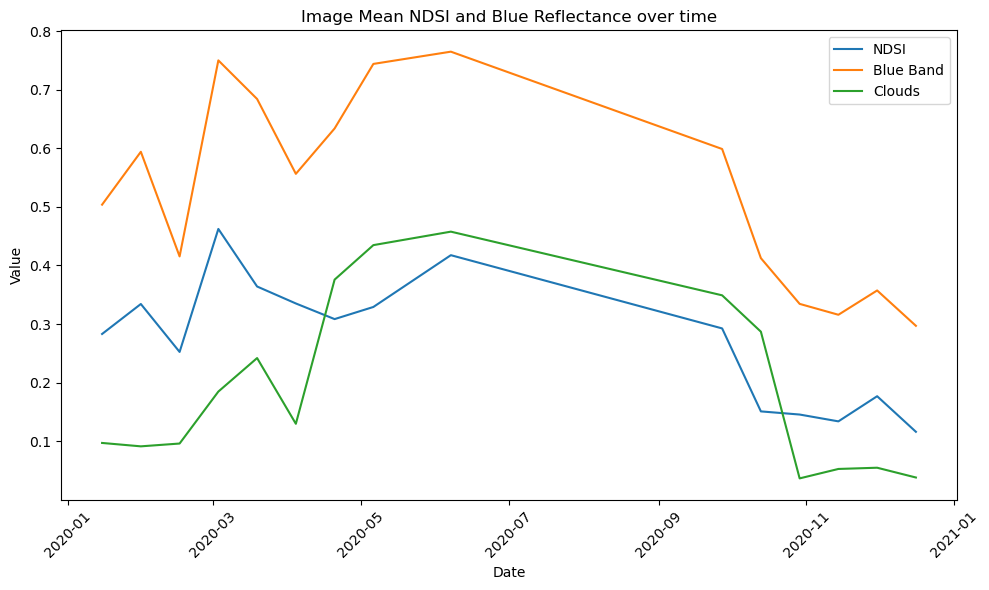

In [21]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(ndsi_df['date'], ndsi_df[['ndsi', 'blue', 'clouds']])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Image Mean NDSI and Blue Reflectance over time')
plt.legend(['NDSI', 'Blue Band', "Clouds"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
type(ndsi_all.aggregate_array('SR_B2').getInfo()[0])

float

In [23]:
 # landsat_filtered.getInfo()

In [24]:
# landsat_filtered.getInfo()['properties'] 
# landsat_filtered.getInfo()['features']
type(landsat_filtered.getInfo()['features'])

list

In [25]:
# cloud = ee.Image(landsat_filtered.first().getNumber("CLOUD_COVER_LAND")).rename('CLOUD_COVER_LAND')

# Map = geemap.Map()
# Map.setCenter(86.9250,  27.9881, 8);


# Map.addLayer(cloud, {}, 'Clouds over Everest')
# Map

In [26]:
landsat_filtered.aggregate_array('CLOUD_COVER').getInfo()

[9.7,
 9.12,
 9.6,
 18.47,
 24.19,
 12.97,
 37.58,
 43.47,
 45.77,
 34.9,
 28.69,
 3.65,
 5.26,
 5.47,
 3.8]

In [27]:
# Define ColorBrewer palette manually
color_palette = {
    'Set1': ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999'],
    'Set2': ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3'],
    'Set3': ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9']
}

# Example usage
palette_name = 'Set1'
palette = color_palette[palette_name]

In [28]:
# Create a map to display the Landsat images
Map = geemap.Map()
Map.setCenter(86.9250,  27.9881, 12);

# Add the Landsat images to the map (just first image)
first_image = landsat_filtered.first().clip(polygon)

clouds = landsat_filtered.first().select('QA_PIXEL').clip(polygon)

Map.addLayer(first_image, vis_params, 'Landsat 8')
Map.addLayer(clouds, {'palette': palette, 'opacity': 0.3}, 'cloud mask')

Map

Map(center=[27.9881, 86.925], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [19]:
# Create a map to display the Landsat images
Map = geemap.Map()
Map.setCenter(86.9250, 27.9881, 12)

# Add the Landsat images to the map (just first image)
first_image = landsat_filtered.first().clip(polygon)

# Add cloud mask
clouds = landsat_filtered.first().select('QA_PIXEL').clip(polygon)

# Define a palette for the cloud mask
palette = ['white', 'blue']

# Add layers to the map
Map.addLayer(first_image, vis_params, 'Landsat 8')
Map.addLayer(clouds, {'palette': palette, 'opacity': 0.6}, 'cloud mask')

# Add legend
legend_keys = ['Landsat 8', 'Cloud Mask']
legend_colors = ['#0000FF', '#FFFFFF']
Map.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

# Display the map
Map


Map(center=[27.9881, 86.925], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [29]:
landsat_filtered.first().get('CLOUD_COVER')

### More on the cloud mask

In [30]:
# https://github.com/gee-community/geemap/issues/1095

def fmask(image):
        # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
        # Bit 0 - Fill
        # Bit 1 - Dilated Cloud
        # Bit 2 - Cirrus
        # Bit 3 - Cloud
        # Bit 4 - Cloud Shadow
        qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)

        # Apply the scaling factors to the appropriate bands.
        opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

        # Replace the original bands with the scaled ones and apply the masks.
        return image.addBands(opticalBands, None, True).updateMask(qaMask)

In [31]:
# Map the function over one year of data.
new_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                    .filterDate('2023-06-10','2023-10-31') \
                    .filterBounds(polygon) \
                    .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
                    .filter(ee.Filter.eq('WRS_PATH', path)) \
                    .filter(ee.Filter.eq('WRS_ROW', row))

collection_masked = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                    .filterDate('2023-06-10','2023-10-31') \
                    .filterBounds(polygon) \
                    .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
                    .filter(ee.Filter.eq('WRS_PATH', path)) \
                    .filter(ee.Filter.eq('WRS_ROW', row)) \
                    .map(fmask)

print(f"Number of images: {new_collection.size().getInfo()}")

Number of images: 4


In [32]:
# Create a map to display the Landsat images
Map = geemap.Map()
Map.setCenter(86.9250, 27.9881, 9)

# Add the Landsat images to the map (just first image)


# Add layers to the map
Map.addLayer(new_collection.first(), vis_params, 'Landsat 8 image')
Map.addLayer(collection_masked.first(), {}, 'Landsat 8 - fmask applied')

# Display the map
Map

Map(center=[27.9881, 86.925], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [133]:
# https://github.com/gee-community/geemap/blob/ca365d23a10dbbbb29ff3ff5cd29acc89f42d10f/geemap/timelapse.py#L1740
# geemap.landsat_timelapse(polygon)


In [82]:
keep_properties = ['SUN_AZIMUTH',
'SUN_ELEVATION',
 'UTM_ZONE',
 'DATE_ACQUIRED',
 'system:time_end',
'CLOUD_COVER',
 'CLOUD_COVER_LAND',
'REFLECTANCE_ADD_BAND_2',
'REFLECTANCE_ADD_BAND_3',
 'REFLECTANCE_ADD_BAND_4',
 'REFLECTANCE_ADD_BAND_5',
'REFLECTANCE_ADD_BAND_6',
'REFLECTANCE_ADD_BAND_7',
'REFLECTANCE_MULT_BAND_2',
'REFLECTANCE_MULT_BAND_3',
'REFLECTANCE_MULT_BAND_4',
 'REFLECTANCE_MULT_BAND_5',
'REFLECTANCE_MULT_BAND_6',
'REFLECTANCE_MULT_BAND_7']
keep_properties

['SUN_AZIMUTH',
 'SUN_ELEVATION',
 'UTM_ZONE',
 'DATE_ACQUIRED',
 'system:time_end',
 'CLOUD_COVER',
 'CLOUD_COVER_LAND',
 'REFLECTANCE_ADD_BAND_2',
 'REFLECTANCE_ADD_BAND_3',
 'REFLECTANCE_ADD_BAND_4',
 'REFLECTANCE_ADD_BAND_5',
 'REFLECTANCE_ADD_BAND_6',
 'REFLECTANCE_ADD_BAND_7',
 'REFLECTANCE_MULT_BAND_2',
 'REFLECTANCE_MULT_BAND_3',
 'REFLECTANCE_MULT_BAND_4',
 'REFLECTANCE_MULT_BAND_5',
 'REFLECTANCE_MULT_BAND_6',
 'REFLECTANCE_MULT_BAND_7']

In [80]:
landsat_filtered.aggregate_array('SUN_AZIMUTH').getInfo()

[151.14149705,
 147.8205597,
 144.19048491,
 140.19208453,
 135.56218978,
 129.7812287,
 122.36004724,
 113.36814854,
 97.86630528,
 142.98819729,
 149.65983708,
 154.06800993,
 156.35617154,
 156.79128165,
 155.72027658]

In [88]:
# ALL FEATURES
landsat_filtered.getInfo()['features']

[]

In [140]:
landsat_filtered.aggregate_array("CLOUD_COVER").getInfo()

[9.7,
 9.12,
 9.6,
 18.47,
 24.19,
 12.97,
 37.58,
 43.47,
 45.77,
 34.9,
 28.69,
 3.65,
 5.26,
 5.47,
 3.8]

In [141]:
# image = landsat_filtered.getInfo()['features']
# image

#### ISSUES with getting properties

In [81]:
# Define the list of bands to analyze
bands = ['B2', 'B3', 'B4', 'B5', 'B6']

# Create a function to calculate statistics for each image
def calculate_stats(image):
    date_acquired = ee.Date(image.get('DATE_ACQUIRED')).format('YYYY-MM-dd').getInfo()
    stats = {'DATE_ACQUIRED': date_acquired}
    for band in bands:
        band_image = image.select(band)
        band_stats = band_image.reduceRegion(
            reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
            geometry=image.geometry(),
            scale=30
        ).getInfo()
        stats[f'{band}_mean'] = band_stats[f'{band}_mean']
        stats[f'{band}_std_dev'] = band_stats[f'{band}_stdDev']
        stats[f'{band}_max'] = band_stats[f'{band}_mean'] + band_stats[f'{band}_stdDev']
        stats[f'{band}_min'] = band_stats[f'{band}_mean'] - band_stats[f'{band}_stdDev']
        stats[f'{band}_median'] = band_stats[f'{band}_median']
    return stats

# Map the function over the image collection
image_stats = landsat.map(calculate_stats)

# Convert the resulting image collection to a list
image_stats_list = image_stats.getInfo()

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(image_stats_list)

# Print the DataFrame
print(df)


EEException: A mapped function's arguments cannot be used in client-side operations

#### 

#### 